# **Part 1: Univariate LSTM**
 (Keras / TensorFlow)

Purpose:
- Train a univariate LSTM to predict next season's `target_log1p` using prior `n_steps` seasons.
- Use the full FE master (`final_training_master.csv`) which contains `player_id`.
- Save model, predictions and training diagnostics to Drive.


In [ ]:
import pandas as pd

fe_path = "/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe.csv"

# Load only first row
df_check = pd.read_csv(fe_path, nrows=1)
print("Columns:", df_check.columns.tolist()[:20])  # first 20 columns
print("Does player_id exist?:", "player_id" in df_check.columns)
print("First row:")
print(df_check.head(1).T)


Columns: ['player_id', 'season', 'name', 'age_at_season_start', 'position', 'sub_position', 'current_club_id', 'current_club_domestic_competition_id', 'played_any', 'appearances_count', 'total_minutes', 'minutes_per_appearance', 'goals', 'assists', 'goals_per90', 'assists_per90', 'target_eur', 'target_log1p', 'target_choice', 'sb_shots']
Does player_id exist?: True
First row:
                                              0
player_id                                    10
season                                     2012
name                             Miroslav Klose
age_at_season_start                        34.0
position                                 Attack
...                                         ...
sb_passes_scaled                      -0.049753
reddit_mean_compound_scaled           -0.018729
num_injuries_scaled                   -0.059164
transfers_sum_fee_scaled              -0.146907
days_since_last_transfer_scaled       -0.361545

[185 rows x 1 columns]


#Cell 1 — Imports & paths
1. Load libraries, set paths to the full FE file and an output folder for LSTM artifacts.

In [ ]:
# Cell 1: Imports & paths
import os
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

PROJ = Path("/content/drive/MyDrive/player_value_prediction_project")
MASTER_DIR = PROJ / "data" / "processed" / "master"
FULL_FE = MASTER_DIR / "sandbox" / "final_training_master_fe.csv"
SANDBOX = MASTER_DIR / "sandbox"
OUT_DIR = SANDBOX / "models_lstm_univariate"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Full FE path:", FULL_FE)
print("Output directory:", OUT_DIR)


Full FE path: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe.csv
Output directory: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm_univariate


#Cell 2 — Load & inspect dataset
2. Load the full FE file and check that player_id, season and target exist. This cell prints shape and a few sample rows.

In [ ]:
# Cell 2: Load full FE
df = pd.read_csv(FULL_FE, low_memory=False)
print("Loaded shape:", df.shape)
display(df.head(3))
print("\nColumns sample:", df.columns[:40].tolist())

# Check required columns
required = ['player_id','season','target_log1p']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError("Missing required columns: " + ", ".join(missing))


Loaded shape: (87223, 185)


,player_id,season,name,age_at_season_start,position,sub_position,current_club_id,current_club_domestic_competition_id,played_any,appearances_count,...,goals_per90_scaled,assists_per90_scaled,goals_per_min_scaled,sb_xg_scaled,sb_shots_scaled,sb_passes_scaled,reddit_mean_compound_scaled,num_injuries_scaled,transfers_sum_fee_scaled,days_since_last_transfer_scaled
0,10,2012,Miroslav Klose,34.0,Attack,Centre-Forward,398.0,IT1,1,36,...,0.768854,0.020280,0.768854,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
1,10,2013,Miroslav Klose,35.0,Attack,Centre-Forward,398.0,IT1,1,29,...,0.356620,0.220335,0.356620,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
2,10,2014,Miroslav Klose,36.0,Attack,Centre-Forward,398.0,IT1,1,40,...,0.896447,0.528119,0.896447,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545



Columns sample: ['player_id', 'season', 'name', 'age_at_season_start', 'position', 'sub_position', 'current_club_id', 'current_club_domestic_competition_id', 'played_any', 'appearances_count', 'total_minutes', 'minutes_per_appearance', 'goals', 'assists', 'goals_per90', 'assists_per90', 'target_eur', 'target_log1p', 'target_choice', 'sb_shots', 'sb_xg', 'sb_goals', 'sb_passes', 'sb_passes_completed', 'sb_tackles', 'sb_interceptions', 'sb_clearances', 'sb_fouls_committed', 'sb_pass_completion', 'sb_xg_per_shot', 'sb_goals_per_shot', 'sb_tackles_per90', 'sb_interceptions_per90', 'sb_clearances_per90', 'sb_fouls_committed_per90', 'reddit_num_posts', 'reddit_num_comments_used', 'reddit_pos_ratio', 'reddit_neu_ratio', 'reddit_neg_ratio']


#Cell 3 — Create season_start_year & sort
3. Create a numeric season_start_year (if missing) and sort rows by player_id and season_start_year to ensure temporal order.

In [ ]:
# Cell 3: season_start_year + sort
def extract_year(s):
    try:
        if pd.isna(s): return np.nan
        s = str(s)
        if '/' in s or '-' in s:
            return int(s.split('/')[0].split('-')[0])
        return int(s)
    except:
        return np.nan

if 'season_start_year' not in df.columns:
    df['season_start_year'] = df['season'].apply(extract_year)

# Ensure sorted
df = df.sort_values(['player_id','season_start_year']).reset_index(drop=True)
print("Unique players:", df['player_id'].nunique())
print("Seasons found:", sorted(df['season_start_year'].unique())[:5], "...", sorted(df['season_start_year'].unique())[-5:])


Unique players: 25689
Seasons found: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016)] ... [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


#Cell 4 — Build univariate sequences
4. Create sequences of past n_steps target_log1p values and the next-season target. Also collect target season years so we can split time-aware.

In [ ]:
# Cell 4: Prepare sequences
n_steps = 3   # change if you want longer history
X_list, y_list, y_years = [], [], []

for pid, g in df.groupby('player_id', sort=False):
    g_sorted = g.sort_values('season_start_year')
    vals = g_sorted['target_log1p'].values
    years = g_sorted['season_start_year'].values
    for i in range(len(vals) - n_steps):
        X_list.append(vals[i:i+n_steps])
        y_list.append(vals[i+n_steps])
        y_years.append(years[i+n_steps])

X = np.array(X_list)
y = np.array(y_list)
y_years = np.array(y_years)

print("Total samples:", X.shape[0])
X = X.reshape((X.shape[0], X.shape[1], 1))
print("LSTM input shape:", X.shape)


Total samples: 32733
LSTM input shape: (32733, 3, 1)


#Cell 5 — Time-aware train/test split + scaling
5. Split by target season year: use 75th percentile as cutoff to avoid leakage. Standardize sequences by train mean/std.

In [ ]:
# Cell 5: Time-aware split + simple scaling
cutoff_year = int(np.percentile(y_years, 75))
print("Cutoff year (75th pct):", cutoff_year)

train_mask = y_years <= cutoff_year
test_mask = y_years > cutoff_year

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# Standardize using train statistics (global mean/std)
train_mean = X_train.mean()
train_std = X_train.std() if X_train.std() != 0 else 1.0
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std


Cutoff year (75th pct): 2022
Train samples: 26094 Test samples: 6639


#Cell 6 — Define, train & save LSTM
6. Build a small LSTM model in Keras, train with early stopping, and save the best weights to Drive.

In [ ]:
# Cell 6: Build and train LSTM (Keras)
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
ckpt_path = str(OUT_DIR / "lstm_univariate_best.h5")
mc = ModelCheckpoint(ckpt_path, save_best_only=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=80,
    batch_size=128,
    callbacks=[es, mc],
    verbose=2
)

print("Model saved to:", ckpt_path)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


174/174 - 4s - 23ms/step - loss: 84.8430 - root_mean_squared_error: 9.2110 - val_loss: 2.5444 - val_root_mean_squared_error: 1.5951
Epoch 2/80


174/174 - 2s - 9ms/step - loss: 1.8734 - root_mean_squared_error: 1.3687 - val_loss: 2.1630 - val_root_mean_squared_error: 1.4707
Epoch 3/80


174/174 - 4s - 20ms/step - loss: 1.7446 - root_mean_squared_error: 1.3208 - val_loss: 1.9880 - val_root_mean_squared_error: 1.4100
Epoch 4/80


174/174 - 1s - 8ms/step - loss: 1.6694 - root_mean_squared_error: 1.2921 - val_loss: 1.8568 - val_root_mean_squared_error: 1.3627
Epoch 5/80


174/174 - 1s - 8ms/step - loss: 1.6021 - root_mean_squared_error: 1.2657 - val_loss: 1.7247 - val_root_mean_squared_error: 1.3133
Epoch 6/80


174/174 - 1s - 8ms/step - loss: 1.5374 - root_mean_squared_error: 1.2399 - val_loss: 1.5895 - val_root_mean_squared_error: 1.2608
Epoch 7/80


174/174 - 3s - 15ms/step - loss: 1.4743 - root_mean_squared_error: 1.2142 - val_loss: 1.4550 - val_root_mean_squared_error: 1.2062
Epoch 8/80


174/174 - 1s - 8ms/step - loss: 1.4122 - root_mean_squared_error: 1.1883 - val_loss: 1.3256 - val_root_mean_squared_error: 1.1514
Epoch 9/80


174/174 - 1s - 8ms/step - loss: 1.3502 - root_mean_squared_error: 1.1620 - val_loss: 1.2029 - val_root_mean_squared_error: 1.0968
Epoch 10/80


174/174 - 4s - 25ms/step - loss: 1.2876 - root_mean_squared_error: 1.1347 - val_loss: 1.0856 - val_root_mean_squared_error: 1.0419
Epoch 11/80


174/174 - 2s - 9ms/step - loss: 1.2251 - root_mean_squared_error: 1.1068 - val_loss: 0.9753 - val_root_mean_squared_error: 0.9875
Epoch 12/80


174/174 - 1s - 8ms/step - loss: 1.1663 - root_mean_squared_error: 1.0799 - val_loss: 0.8788 - val_root_mean_squared_error: 0.9374
Epoch 13/80


174/174 - 2s - 14ms/step - loss: 1.1155 - root_mean_squared_error: 1.0562 - val_loss: 0.8020 - val_root_mean_squared_error: 0.8956
Epoch 14/80


174/174 - 3s - 14ms/step - loss: 1.0744 - root_mean_squared_error: 1.0365 - val_loss: 0.7454 - val_root_mean_squared_error: 0.8634
Epoch 15/80


174/174 - 1s - 7ms/step - loss: 1.0423 - root_mean_squared_error: 1.0209 - val_loss: 0.7057 - val_root_mean_squared_error: 0.8401
Epoch 16/80


174/174 - 1s - 7ms/step - loss: 1.0180 - root_mean_squared_error: 1.0089 - val_loss: 0.6783 - val_root_mean_squared_error: 0.8236
Epoch 17/80


174/174 - 3s - 18ms/step - loss: 0.9999 - root_mean_squared_error: 1.0000 - val_loss: 0.6589 - val_root_mean_squared_error: 0.8117
Epoch 18/80


174/174 - 3s - 19ms/step - loss: 0.9866 - root_mean_squared_error: 0.9933 - val_loss: 0.6445 - val_root_mean_squared_error: 0.8028
Epoch 19/80


174/174 - 1s - 7ms/step - loss: 0.9767 - root_mean_squared_error: 0.9883 - val_loss: 0.6334 - val_root_mean_squared_error: 0.7959
Epoch 20/80


174/174 - 1s - 7ms/step - loss: 0.9692 - root_mean_squared_error: 0.9845 - val_loss: 0.6248 - val_root_mean_squared_error: 0.7904
Epoch 21/80


174/174 - 3s - 15ms/step - loss: 0.9635 - root_mean_squared_error: 0.9816 - val_loss: 0.6180 - val_root_mean_squared_error: 0.7861
Epoch 22/80


174/174 - 1s - 8ms/step - loss: 0.9590 - root_mean_squared_error: 0.9793 - val_loss: 0.6127 - val_root_mean_squared_error: 0.7828
Epoch 23/80


174/174 - 4s - 20ms/step - loss: 0.9556 - root_mean_squared_error: 0.9775 - val_loss: 0.6086 - val_root_mean_squared_error: 0.7801
Epoch 24/80


174/174 - 2s - 12ms/step - loss: 0.9528 - root_mean_squared_error: 0.9761 - val_loss: 0.6054 - val_root_mean_squared_error: 0.7781
Epoch 25/80


174/174 - 2s - 10ms/step - loss: 0.9506 - root_mean_squared_error: 0.9750 - val_loss: 0.6028 - val_root_mean_squared_error: 0.7764
Epoch 26/80


174/174 - 1s - 7ms/step - loss: 0.9487 - root_mean_squared_error: 0.9740 - val_loss: 0.6008 - val_root_mean_squared_error: 0.7751
Epoch 27/80


174/174 - 1s - 8ms/step - loss: 0.9472 - root_mean_squared_error: 0.9733 - val_loss: 0.5991 - val_root_mean_squared_error: 0.7740
Epoch 28/80


174/174 - 1s - 8ms/step - loss: 0.9459 - root_mean_squared_error: 0.9726 - val_loss: 0.5977 - val_root_mean_squared_error: 0.7731
Epoch 29/80


174/174 - 1s - 7ms/step - loss: 0.9448 - root_mean_squared_error: 0.9720 - val_loss: 0.5965 - val_root_mean_squared_error: 0.7724
Epoch 30/80


174/174 - 1s - 8ms/step - loss: 0.9439 - root_mean_squared_error: 0.9715 - val_loss: 0.5955 - val_root_mean_squared_error: 0.7717
Epoch 31/80


174/174 - 1s - 8ms/step - loss: 0.9431 - root_mean_squared_error: 0.9711 - val_loss: 0.5946 - val_root_mean_squared_error: 0.7711
Epoch 32/80


174/174 - 2s - 13ms/step - loss: 0.9423 - root_mean_squared_error: 0.9707 - val_loss: 0.5938 - val_root_mean_squared_error: 0.7706
Epoch 33/80


174/174 - 2s - 14ms/step - loss: 0.9417 - root_mean_squared_error: 0.9704 - val_loss: 0.5931 - val_root_mean_squared_error: 0.7701
Epoch 34/80


174/174 - 1s - 7ms/step - loss: 0.9411 - root_mean_squared_error: 0.9701 - val_loss: 0.5924 - val_root_mean_squared_error: 0.7697
Epoch 35/80


174/174 - 3s - 15ms/step - loss: 0.9406 - root_mean_squared_error: 0.9698 - val_loss: 0.5917 - val_root_mean_squared_error: 0.7692
Epoch 36/80


174/174 - 1s - 7ms/step - loss: 0.9401 - root_mean_squared_error: 0.9696 - val_loss: 0.5911 - val_root_mean_squared_error: 0.7688
Epoch 37/80


174/174 - 1s - 7ms/step - loss: 0.9397 - root_mean_squared_error: 0.9694 - val_loss: 0.5905 - val_root_mean_squared_error: 0.7684
Epoch 38/80


174/174 - 1s - 7ms/step - loss: 0.9393 - root_mean_squared_error: 0.9692 - val_loss: 0.5899 - val_root_mean_squared_error: 0.7680
Epoch 39/80


174/174 - 1s - 7ms/step - loss: 0.9389 - root_mean_squared_error: 0.9690 - val_loss: 0.5893 - val_root_mean_squared_error: 0.7677
Epoch 40/80


174/174 - 2s - 11ms/step - loss: 0.9386 - root_mean_squared_error: 0.9688 - val_loss: 0.5887 - val_root_mean_squared_error: 0.7673
Epoch 41/80


174/174 - 3s - 16ms/step - loss: 0.9382 - root_mean_squared_error: 0.9686 - val_loss: 0.5881 - val_root_mean_squared_error: 0.7669
Epoch 42/80


174/174 - 2s - 10ms/step - loss: 0.9379 - root_mean_squared_error: 0.9685 - val_loss: 0.5876 - val_root_mean_squared_error: 0.7666
Epoch 43/80


174/174 - 1s - 8ms/step - loss: 0.9376 - root_mean_squared_error: 0.9683 - val_loss: 0.5871 - val_root_mean_squared_error: 0.7662
Epoch 44/80


174/174 - 1s - 7ms/step - loss: 0.9373 - root_mean_squared_error: 0.9681 - val_loss: 0.5866 - val_root_mean_squared_error: 0.7659
Epoch 45/80


174/174 - 1s - 7ms/step - loss: 0.9370 - root_mean_squared_error: 0.9680 - val_loss: 0.5861 - val_root_mean_squared_error: 0.7656
Epoch 46/80


174/174 - 3s - 15ms/step - loss: 0.9367 - root_mean_squared_error: 0.9679 - val_loss: 0.5857 - val_root_mean_squared_error: 0.7653
Epoch 47/80


174/174 - 1s - 8ms/step - loss: 0.9365 - root_mean_squared_error: 0.9677 - val_loss: 0.5853 - val_root_mean_squared_error: 0.7650
Epoch 48/80


174/174 - 2s - 12ms/step - loss: 0.9362 - root_mean_squared_error: 0.9676 - val_loss: 0.5849 - val_root_mean_squared_error: 0.7648
Epoch 49/80


174/174 - 2s - 13ms/step - loss: 0.9359 - root_mean_squared_error: 0.9674 - val_loss: 0.5846 - val_root_mean_squared_error: 0.7646
Epoch 50/80


174/174 - 1s - 8ms/step - loss: 0.9357 - root_mean_squared_error: 0.9673 - val_loss: 0.5842 - val_root_mean_squared_error: 0.7644
Epoch 51/80


174/174 - 2s - 14ms/step - loss: 0.9354 - root_mean_squared_error: 0.9672 - val_loss: 0.5839 - val_root_mean_squared_error: 0.7642
Epoch 52/80


174/174 - 3s - 14ms/step - loss: 0.9352 - root_mean_squared_error: 0.9670 - val_loss: 0.5837 - val_root_mean_squared_error: 0.7640
Epoch 53/80


174/174 - 1s - 8ms/step - loss: 0.9349 - root_mean_squared_error: 0.9669 - val_loss: 0.5834 - val_root_mean_squared_error: 0.7638
Epoch 54/80


174/174 - 3s - 14ms/step - loss: 0.9347 - root_mean_squared_error: 0.9668 - val_loss: 0.5832 - val_root_mean_squared_error: 0.7636
Epoch 55/80


174/174 - 3s - 19ms/step - loss: 0.9344 - root_mean_squared_error: 0.9667 - val_loss: 0.5829 - val_root_mean_squared_error: 0.7635
Epoch 56/80


174/174 - 2s - 9ms/step - loss: 0.9342 - root_mean_squared_error: 0.9665 - val_loss: 0.5827 - val_root_mean_squared_error: 0.7634
Epoch 57/80


174/174 - 3s - 15ms/step - loss: 0.9339 - root_mean_squared_error: 0.9664 - val_loss: 0.5825 - val_root_mean_squared_error: 0.7632
Epoch 58/80


174/174 - 1s - 7ms/step - loss: 0.9337 - root_mean_squared_error: 0.9663 - val_loss: 0.5823 - val_root_mean_squared_error: 0.7631
Epoch 59/80


174/174 - 1s - 7ms/step - loss: 0.9335 - root_mean_squared_error: 0.9662 - val_loss: 0.5821 - val_root_mean_squared_error: 0.7630
Epoch 60/80


174/174 - 1s - 7ms/step - loss: 0.9332 - root_mean_squared_error: 0.9660 - val_loss: 0.5819 - val_root_mean_squared_error: 0.7628
Epoch 61/80


174/174 - 1s - 7ms/step - loss: 0.9330 - root_mean_squared_error: 0.9659 - val_loss: 0.5817 - val_root_mean_squared_error: 0.7627
Epoch 62/80


174/174 - 2s - 9ms/step - loss: 0.9327 - root_mean_squared_error: 0.9658 - val_loss: 0.5815 - val_root_mean_squared_error: 0.7626
Epoch 63/80


174/174 - 2s - 13ms/step - loss: 0.9325 - root_mean_squared_error: 0.9657 - val_loss: 0.5814 - val_root_mean_squared_error: 0.7625
Epoch 64/80


174/174 - 2s - 11ms/step - loss: 0.9323 - root_mean_squared_error: 0.9655 - val_loss: 0.5812 - val_root_mean_squared_error: 0.7623
Epoch 65/80


174/174 - 2s - 14ms/step - loss: 0.9320 - root_mean_squared_error: 0.9654 - val_loss: 0.5810 - val_root_mean_squared_error: 0.7622
Epoch 66/80


174/174 - 2s - 14ms/step - loss: 0.9318 - root_mean_squared_error: 0.9653 - val_loss: 0.5808 - val_root_mean_squared_error: 0.7621
Epoch 67/80


174/174 - 1s - 7ms/step - loss: 0.9316 - root_mean_squared_error: 0.9652 - val_loss: 0.5806 - val_root_mean_squared_error: 0.7620
Epoch 68/80


174/174 - 1s - 7ms/step - loss: 0.9314 - root_mean_squared_error: 0.9651 - val_loss: 0.5804 - val_root_mean_squared_error: 0.7619
Epoch 69/80


174/174 - 3s - 20ms/step - loss: 0.9311 - root_mean_squared_error: 0.9649 - val_loss: 0.5803 - val_root_mean_squared_error: 0.7618
Epoch 70/80


174/174 - 3s - 15ms/step - loss: 0.9309 - root_mean_squared_error: 0.9648 - val_loss: 0.5801 - val_root_mean_squared_error: 0.7616
Epoch 71/80


174/174 - 1s - 7ms/step - loss: 0.9306 - root_mean_squared_error: 0.9647 - val_loss: 0.5799 - val_root_mean_squared_error: 0.7615
Epoch 72/80


174/174 - 1s - 7ms/step - loss: 0.9304 - root_mean_squared_error: 0.9646 - val_loss: 0.5797 - val_root_mean_squared_error: 0.7614
Epoch 73/80


174/174 - 3s - 15ms/step - loss: 0.9302 - root_mean_squared_error: 0.9645 - val_loss: 0.5795 - val_root_mean_squared_error: 0.7613
Epoch 74/80


174/174 - 3s - 14ms/step - loss: 0.9299 - root_mean_squared_error: 0.9643 - val_loss: 0.5793 - val_root_mean_squared_error: 0.7612
Epoch 75/80


174/174 - 1s - 7ms/step - loss: 0.9297 - root_mean_squared_error: 0.9642 - val_loss: 0.5792 - val_root_mean_squared_error: 0.7610
Epoch 76/80


174/174 - 2s - 9ms/step - loss: 0.9295 - root_mean_squared_error: 0.9641 - val_loss: 0.5790 - val_root_mean_squared_error: 0.7609
Epoch 77/80


174/174 - 3s - 18ms/step - loss: 0.9292 - root_mean_squared_error: 0.9640 - val_loss: 0.5788 - val_root_mean_squared_error: 0.7608
Epoch 78/80


174/174 - 2s - 10ms/step - loss: 0.9290 - root_mean_squared_error: 0.9638 - val_loss: 0.5786 - val_root_mean_squared_error: 0.7607
Epoch 79/80


174/174 - 1s - 7ms/step - loss: 0.9287 - root_mean_squared_error: 0.9637 - val_loss: 0.5785 - val_root_mean_squared_error: 0.7606
Epoch 80/80


174/174 - 3s - 15ms/step - loss: 0.9285 - root_mean_squared_error: 0.9636 - val_loss: 0.5783 - val_root_mean_squared_error: 0.7605
Model saved to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm_univariate/lstm_univariate_best.h5


#Cell 7 — Evaluate + save outputs
7. Evaluate on test set, plot training history, save predictions and loss plot.

Test RMSE (univariate LSTM): 0.6194


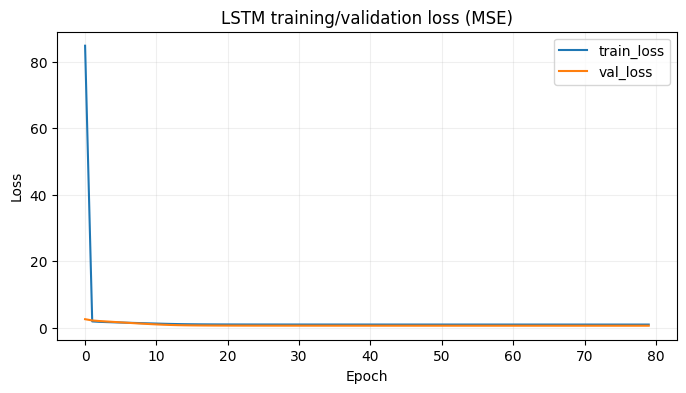

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saved predictions to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm_univariate/lstm_univariate_predictions.csv


In [ ]:
# Cell 7: Evaluate and save artifacts
loss, rmse = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test RMSE (univariate LSTM): {rmse:.4f}")

# Plot loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("LSTM training/validation loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.2)
plt.savefig(OUT_DIR / "lstm_loss.png", dpi=150)
plt.show()

# Predictions & save
y_pred = model.predict(X_test_scaled).flatten()
res = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred, 'target_year': y_years[test_mask]})
res.to_csv(OUT_DIR / "lstm_univariate_predictions.csv", index=False)
print("Saved predictions to:", OUT_DIR / "lstm_univariate_predictions.csv")


# Cell 8 — Quick diagnostics
8. Show a sample of predictions vs true values and simple metrics (MAE, RMSE).

RMSE: 0.6193692036413672 MAE: 0.3795860330883619


,y_true,y_pred,target_year
0,13.815512,13.859530,2023
1,13.815512,13.441968,2024
2,10.819798,11.310355,2023
3,12.899222,12.738318,2023
4,12.611541,12.604338,2024
5,16.118096,16.138996,2023
6,14.914123,15.818188,2024
7,13.304687,13.166732,2023
8,13.304687,12.995323,2024
9,10.819798,11.903382,2023


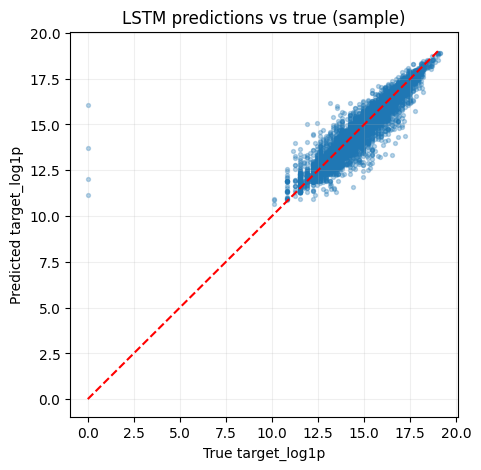

from matplotlib import pyplot as plt
_df_0['y_true'].plot(kind='hist', bins=20, title='y_true')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['y_pred'].plot(kind='hist', bins=20, title='y_pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['target_year'].plot(kind='hist', bins=20, title='target_year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='y_true', y='y_pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='y_pred', y='target_year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['y_true'].plot(kind='line', figsize=(8, 4), title='y_true')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['y_pred'].plot(kind='line', figsize=(8, 4), title='y_pred')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['target_year'].plot(kind='line', figsize=(8, 4), title='target_year')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Cell 8: Diagnostics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse_val = np.sqrt(mean_squared_error(res['y_true'], res['y_pred']))
mae_val = mean_absolute_error(res['y_true'], res['y_pred'])
print("RMSE:", rmse_val, "MAE:", mae_val)

display(res.head(10))

# Scatter
plt.figure(figsize=(5,5))
plt.scatter(res['y_true'], res['y_pred'], alpha=0.3, s=8)
plt.xlabel("True target_log1p")
plt.ylabel("Predicted target_log1p")
plt.title("LSTM predictions vs true (sample)")
plt.plot([res['y_true'].min(), res['y_true'].max()], [res['y_true'].min(), res['y_true'].max()], 'r--')
plt.grid(alpha=0.2)
plt.show()


# **Part 2: Multivariate LSTM**
Purpose:
- Extend univariate LSTM by adding multiple input features alongside `target_log1p`.
- Input: sequences of [target_log1p + performance + transfers + injuries + sentiment].
- Output: next season's `target_log1p`.
- Framework: Keras (TensorFlow backend).


In [ ]:
import numpy as np


In [ ]:
# Reload dataset if needed
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)
df = df.sort_values(['player_id','season']).reset_index(drop=True)

print("Shape:", df.shape)
print("Columns sample:", df.columns[:20])


Shape: (87223, 185)
Columns sample: Index(['player_id', 'season', 'name', 'age_at_season_start', 'position',
       'sub_position', 'current_club_id',
       'current_club_domestic_competition_id', 'played_any',
       'appearances_count', 'total_minutes', 'minutes_per_appearance', 'goals',
       'assists', 'goals_per90', 'assists_per90', 'target_eur', 'target_log1p',
       'target_choice', 'sb_shots'],
      dtype='object')


#Cell 9 – Select features
1. Select features to include in the multivariate sequences.


In [ ]:
# Cell 9: Prepare multivariate sequences

# Candidate multivariate features
multi_features = [
    'target_log1p',          # previous values
    'goals','assists','total_minutes','appearances_count',
    'num_injuries','transfers_sum_fee','transfers_count',
    'reddit_mean_compound','reddit_num_posts'
]

# Keep only those present in df
multi_features = [c for c in multi_features if c in df.columns]
print("Using features:", multi_features)

n_steps = 3  # lookback window
X_list, y_list, y_years = [], [], []

for pid, g in df.groupby('player_id', sort=False):
    g_sorted = g.sort_values('season_start_year')
    vals = g_sorted[multi_features].values
    years = g_sorted['season_start_year'].values
    targs = g_sorted['target_log1p'].values

    for i in range(len(vals) - n_steps):
        X_list.append(vals[i:i+n_steps, :])
        y_list.append(targs[i+n_steps])
        y_years.append(years[i+n_steps])

X_mv = np.array(X_list)
y_mv = np.array(y_list)
y_years_mv = np.array(y_years)

print("Multivariate shape:", X_mv.shape)  # (samples, n_steps, features)
print("y shape:", y_mv.shape)


Using features: ['target_log1p', 'goals', 'assists', 'total_minutes', 'appearances_count', 'num_injuries', 'transfers_sum_fee', 'transfers_count', 'reddit_mean_compound', 'reddit_num_posts']
Multivariate shape: (32733, 3, 10)
y shape: (32733,)


#Cell 10 — Train/test split + scaling

In [ ]:
# Cell 10: Split and scale multivariate sequences

cutoff_year = int(np.percentile(y_years_mv, 75))
print("Cutoff year:", cutoff_year)

train_mask = y_years_mv <= cutoff_year
test_mask = y_years_mv > cutoff_year

X_train_mv, y_train_mv = X_mv[train_mask], y_mv[train_mask]
X_test_mv, y_test_mv = X_mv[test_mask], y_mv[test_mask]

print("Train samples:", X_train_mv.shape[0], "Test samples:", X_test_mv.shape[0])

# Compute mean/std across samples and timesteps, for each feature
feat_means = X_train_mv.mean(axis=(0,1))
feat_stds = X_train_mv.std(axis=(0,1))
feat_stds[feat_stds==0] = 1.0

X_train_mv_scaled = (X_train_mv - feat_means) / feat_stds
X_test_mv_scaled = (X_test_mv - feat_means) / feat_stds


Cutoff year: 2022
Train samples: 26094 Test samples: 6639


#Cell 11 — Define & train multivariate LSTM

In [ ]:
# Cell 11: Build and train multivariate LSTM

from tensorflow.keras.layers import Dropout

tf.random.set_seed(42)
model_mv = Sequential([
    LSTM(128, activation='tanh', input_shape=(n_steps, X_train_mv.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model_mv.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_mv.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt_path_mv = str(OUT_DIR / "lstm_multivariate_best.keras")  # modern format
mc = ModelCheckpoint(ckpt_path_mv, save_best_only=True)

history_mv = model_mv.fit(
    X_train_mv_scaled, y_train_mv,
    validation_split=0.15,
    epochs=100,
    batch_size=128,
    callbacks=[es, mc],
    verbose=2
)

print("Best model saved to:", ckpt_path_mv)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,489 (310.50 KB)

 Trainable params: 79,489 (310.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
174/174 - 7s - 41ms/step - loss: 52.3318 - root_mean_squared_error: 7.2341 - val_loss: 1.8012 - val_root_mean_squared_error: 1.3421
Epoch 2/100
174/174 - 2s - 14ms/step - loss: 2.6124 - root_mean_squared_error: 1.6163 - val_loss: 1.4962 - val_root_mean_squared_error: 1.2232
Epoch 3/100
174/174 - 2s - 14ms/step - loss: 2.2589 - root_mean_squared_error: 1.5030 - val_loss: 1.0609 - val_root_mean_squared_error: 1.0300
Epoch 4/100
174/174 - 2s - 14ms/step - loss: 2.0659 - root_mean_squared_error: 1.4373 - val_loss: 0.9862 - val_root_mean_squared_error: 0.9931
Epoch 5/100
174/174 - 3s - 14ms/step - loss: 1.9583 - root_mean_squared_error: 1.3994 - val_loss: 0.8271 - val_root_mean_squared_error: 0.9095
Epoch 6/100
174/174 - 5s - 28ms/step - loss: 1.8936 - root_mean_squared_error: 1.3761 - val_loss: 0.7524 - val_root_mean_squared_error: 0.8674
Epoch 7/100
174/174 - 3s - 16ms/step - loss: 1.7972 - root_mean_squared_error: 1.3406 - val_loss: 0.6705 - val_root_mean_squared_error: 0.818

#Cell 12 — Evaluate & visualize

Test RMSE (multivariate LSTM): 0.6715


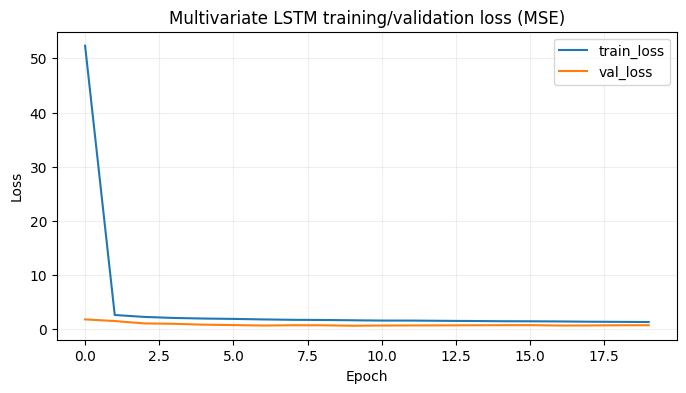

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Saved predictions to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm_univariate/lstm_multivariate_predictions.csv


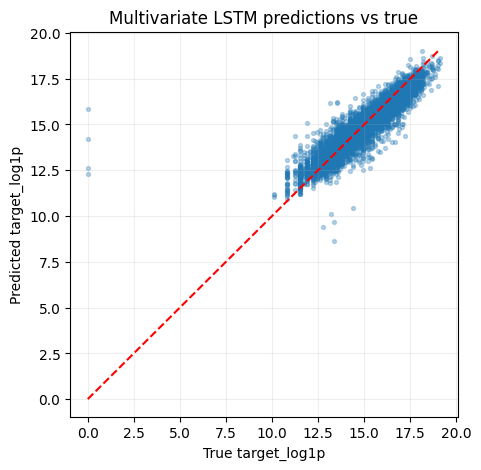

In [ ]:
# Cell 12: Evaluate multivariate LSTM

loss, rmse = model_mv.evaluate(X_test_mv_scaled, y_test_mv, verbose=0)
print(f"Test RMSE (multivariate LSTM): {rmse:.4f}")

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history_mv.history['loss'], label='train_loss')
plt.plot(history_mv.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Multivariate LSTM training/validation loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.2)
plt.show()

# Predictions
y_pred_mv = model_mv.predict(X_test_mv_scaled).flatten()
res_mv = pd.DataFrame({'y_true': y_test_mv, 'y_pred': y_pred_mv, 'target_year': y_years_mv[test_mask]})
res_mv.to_csv(OUT_DIR / "lstm_multivariate_predictions.csv", index=False)
print("Saved predictions to:", OUT_DIR / "lstm_multivariate_predictions.csv")

# Scatter
plt.figure(figsize=(5,5))
plt.scatter(res_mv['y_true'], res_mv['y_pred'], alpha=0.3, s=8)
plt.xlabel("True target_log1p")
plt.ylabel("Predicted target_log1p")
plt.title("Multivariate LSTM predictions vs true")
plt.plot([res_mv['y_true'].min(), res_mv['y_true'].max()],
         [res_mv['y_true'].min(), res_mv['y_true'].max()], 'r--')
plt.grid(alpha=0.2)
plt.show()


# Multivariate LSTM (Tuned) — n_steps=5, stacked LSTM


**Prepare sequences with n_steps=5**

In [ ]:
# Rebuild multivariate sequences with longer history (n_steps=5)

n_steps_tuned = 5
multi_features = [
    'target_log1p','goals','assists','total_minutes','appearances_count',
    'num_injuries','transfers_sum_fee','transfers_count',
    'reddit_mean_compound','reddit_num_posts'
]
multi_features = [c for c in multi_features if c in df.columns]

X_list, y_list, y_years = [], [], []

for pid, g in df.groupby('player_id', sort=False):
    g_sorted = g.sort_values('season_start_year')
    vals = g_sorted[multi_features].values
    years = g_sorted['season_start_year'].values
    targs = g_sorted['target_log1p'].values

    for i in range(len(vals) - n_steps_tuned):
        X_list.append(vals[i:i+n_steps_tuned, :])
        y_list.append(targs[i+n_steps_tuned])
        y_years.append(years[i+n_steps_tuned])

X_mv_tuned = np.array(X_list)
y_mv_tuned = np.array(y_list)
y_years_mv_tuned = np.array(y_years)

print("Shape:", X_mv_tuned.shape, "y:", y_mv_tuned.shape)

# Split by cutoff year
cutoff_year = int(np.percentile(y_years_mv_tuned, 75))
train_mask = y_years_mv_tuned <= cutoff_year
test_mask = y_years_mv_tuned > cutoff_year

X_train_tuned, y_train_tuned = X_mv_tuned[train_mask], y_mv_tuned[train_mask]
X_test_tuned, y_test_tuned = X_mv_tuned[test_mask], y_mv_tuned[test_mask]

print("Train:", X_train_tuned.shape, "Test:", X_test_tuned.shape)

# Scale per feature
feat_means = X_train_tuned.mean(axis=(0,1))
feat_stds = X_train_tuned.std(axis=(0,1))
feat_stds[feat_stds==0] = 1.0

X_train_tuned = (X_train_tuned - feat_means) / feat_stds
X_test_tuned = (X_test_tuned - feat_means) / feat_stds


Shape: (16968, 5, 10) y: (16968,)
Train: (14859, 5, 10) Test: (2109, 5, 10)


**Cell — Build & train stacked LSTM**

In [ ]:
# Stacked LSTM with n_steps=5
tf.random.set_seed(42)
model_mv_tuned = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_steps_tuned, X_train_tuned.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])
model_mv_tuned.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_mv_tuned.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt_path = str(OUT_DIR / "lstm_multivariate_tuned.keras")
mc = ModelCheckpoint(ckpt_path, save_best_only=True)

history_tuned = model_mv_tuned.fit(
    X_train_tuned, y_train_tuned,
    validation_split=0.15,
    epochs=80,
    batch_size=128,
    callbacks=[es, mc],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
99/99 - 8s - 80ms/step - loss: 73.2661 - root_mean_squared_error: 8.5596 - val_loss: 3.6876 - val_root_mean_squared_error: 1.9203
Epoch 2/80
99/99 - 5s - 51ms/step - loss: 2.5180 - root_mean_squared_error: 1.5868 - val_loss: 2.9459 - val_root_mean_squared_error: 1.7164
Epoch 3/80
99/99 - 5s - 47ms/step - loss: 2.0843 - root_mean_squared_error: 1.4437 - val_loss: 1.5192 - val_root_mean_squared_error: 1.2326
Epoch 4/80
99/99 - 3s - 34ms/step - loss: 1.4769 - root_mean_squared_error: 1.2153 - val_loss: 0.8769 - val_root_mean_squared_error: 0.9365
Epoch 5/80
99/99 - 5s - 52ms/step - loss: 1.2286 - root_mean_squared_error: 1.1084 - val_loss: 0.6070 - val_root_mean_squared_error: 0.7791
Epoch 6/80
99/99 - 5s - 51ms/step - loss: 1.0535 - root_mean_squared_error: 1.0264 - val_loss: 0.5304 - val_root_mean_squared_error: 0.7283
Epoch 7/80
99/99 - 3s - 28ms/step - loss: 0.9281 - root_mean_squared_error: 0.9634 - val_loss: 0.4729 - val_root_mean_squared_error: 0.6877
Epoch 8/80
99/99 - 

**Cell — Evaluate tuned model**

Test RMSE (multivariate tuned LSTM): 0.5167


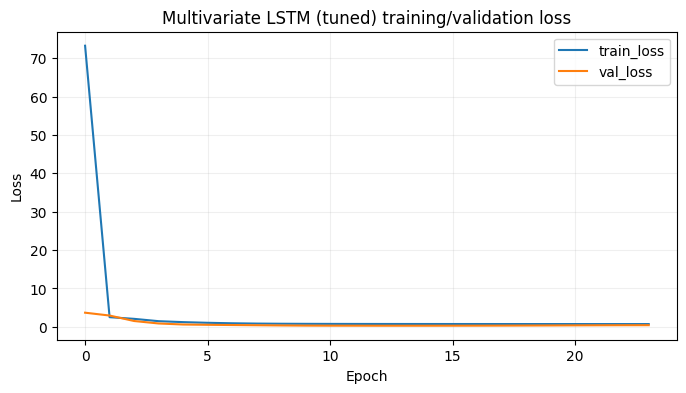

In [ ]:
# Evaluate tuned multivariate LSTM
loss, rmse = model_mv_tuned.evaluate(X_test_tuned, y_test_tuned, verbose=0)
print(f"Test RMSE (multivariate tuned LSTM): {rmse:.4f}")

# Plot history
plt.figure(figsize=(8,4))
plt.plot(history_tuned.history['loss'], label='train_loss')
plt.plot(history_tuned.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Multivariate LSTM (tuned) training/validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.2)
plt.show()


In [ ]:
import os, shutil
from pathlib import Path

base = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox")

# Rename folder if not already
old = base / "models_lstm_univariate"
new = base / "models_lstm"
if old.exists() and not new.exists():
    old.rename(new)

# Create subfolders
for sub in ["univariate", "multivariate", "multivariate_tuned"]:
    (new / sub).mkdir(parents=True, exist_ok=True)

# Move files
shutil.move(str(new/"lstm_univariate_best.h5"), str(new/"univariate/lstm_univariate_best.h5"))
shutil.move(str(new/"lstm_univariate_predictions.csv"), str(new/"univariate/lstm_univariate_predictions.csv"))
shutil.move(str(new/"lstm_loss.png"), str(new/"univariate/lstm_loss.png"))

shutil.move(str(new/"lstm_multivariate_best.keras"), str(new/"multivariate/lstm_multivariate_best.keras"))
shutil.move(str(new/"lstm_multivariate_predictions.csv"), str(new/"multivariate/lstm_multivariate_predictions.csv"))

shutil.move(str(new/"lstm_multivariate_tuned.keras"), str(new/"multivariate_tuned/lstm_multivariate_tuned.keras"))


'/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate_tuned/lstm_multivariate_tuned.keras'

# Part 3: Encoder–Decoder LSTM (multi-step forecasting)

Goal:
- Build an encoder–decoder (seq2seq) LSTM that takes past `n_steps` seasons of multivariate features and predicts the next `H` seasons' `target_log1p`.
- Save model, predictions, and diagnostics to `sandbox/models_lstm/multivariate_tuned/encoder_decoder/`.


### Cell A — Imports & paths
Ensure imports and set paths.


In [ ]:
# Cell A: Imports & paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

PROJ = Path("/content/drive/MyDrive/player_value_prediction_project")
SANDBOX = PROJ / "data" / "processed" / "master" / "sandbox"
FE_PATH = SANDBOX / "final_training_master_fe.csv"
OUT_BASE = SANDBOX / "models_lstm" / "multivariate_tuned" / "encoder_decoder"
OUT_BASE.mkdir(parents=True, exist_ok=True)

print("FE path:", FE_PATH)
print("Outputs:", OUT_BASE)


FE path: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe.csv
Outputs: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate_tuned/encoder_decoder


### Cell B — Load df & pick featur
Load feature-engineered dataset and define multivariate features used as inputs.


In [ ]:
# Cell B: Load df & features
df = pd.read_csv(FE_PATH, low_memory=False)
df = df.sort_values(['player_id','season_start_year']).reset_index(drop=True)

# Multivariate features to use (same as tuned run)
multi_features = [
    'target_log1p','goals','assists','total_minutes','appearances_count',
    'num_injuries','transfers_sum_fee','transfers_count',
    'reddit_mean_compound','reddit_num_posts'
]
multi_features = [c for c in multi_features if c in df.columns]
print("Using features:", multi_features)
print("DF shape:", df.shape)


Using features: ['target_log1p', 'goals', 'assists', 'total_minutes', 'appearances_count', 'num_injuries', 'transfers_sum_fee', 'transfers_count', 'reddit_mean_compound', 'reddit_num_posts']
DF shape: (87223, 185)


# Cell C — Build sequences for multi-step
Construct input sequences (n_steps timesteps) and multi-step targets (H timesteps). We only keep sequences where the full H-target window exists.


In [ ]:
# Cell C: Build encoder-decoder sequences
n_steps = 5    # lookback
H = 3          # forecast horizon (predict next H seasons)
X_list, Y_list, Y_years = [], [], []

for pid, g in df.groupby('player_id', sort=False):
    g = g.sort_values('season_start_year')
    vals = g[multi_features].values
    years = g['season_start_year'].values
    # need i ... i+n_steps-1 as input, and i+n_steps ... i+n_steps+H-1 as outputs
    for i in range(len(vals) - n_steps - H + 1):
        X_seq = vals[i:i+n_steps, :]
        Y_seq = g['target_log1p'].values[i+n_steps : i+n_steps+H]  # shape (H,)
        target_year = years[i+n_steps+H-1]  # last forecast year (use for splitting)
        X_list.append(X_seq)
        Y_list.append(Y_seq)
        Y_years.append(target_year)

X = np.array(X_list)        # (samples, n_steps, n_features)
Y = np.array(Y_list)        # (samples, H)
Y_years = np.array(Y_years)
print("Samples:", X.shape[0], "Input shape:", X.shape[1:], "Target shape:", Y.shape[1:])


Samples: 7971 Input shape: (5, 10) Target shape: (3,)


# Cell D — Time-aware split + scaling
Split into train/test by target year (75th percentile). Standardize inputs using train statistics (per feature).


In [ ]:
# Cell D: Time-aware split + scaling
cutoff = int(np.percentile(Y_years, 75))
print("Cutoff year:", cutoff)

train_mask = Y_years <= cutoff
test_mask = Y_years > cutoff

X_train, Y_train = X[train_mask], Y[train_mask]
X_test, Y_test = X[test_mask], Y[test_mask]
Y_years_test = Y_years[test_mask]

print("Train:", X_train.shape, "Test:", X_test.shape)

# Scale per feature across samples and timesteps
feat_means = X_train.mean(axis=(0,1))   # shape (n_features,)
feat_stds = X_train.std(axis=(0,1))
feat_stds[feat_stds == 0] = 1.0

X_train_scaled = (X_train - feat_means) / feat_stds
X_test_scaled = (X_test - feat_means) / feat_stds


Cutoff year: 2023
Train: (6627, 5, 10) Test: (1344, 5, 10)


#Cell E — Build encoder-decoder model
Define an encoder-decoder LSTM: encoder LSTM -> RepeatVector -> decoder LSTM (return_sequences=True) -> TimeDistributed(Dense(1)) to output H timesteps of target.


In [ ]:
# Cell E: Build encoder-decoder model
n_features = X_train_scaled.shape[2]
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(n_steps, n_features), name="encoder_input")
encoder_lstm = LSTM(latent_dim, activation='tanh', return_state=True, name="encoder_lstm")
_, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder: will output H timesteps of a single value (target_log1p)
decoder_inputs = RepeatVector(H, name="repeat_vector")(state_h)  # using state_h as context
# Alternatively could use states; RepeatVector expects a vector
decoder_lstm = LSTM(latent_dim, activation='tanh', return_sequences=True, name="decoder_lstm")
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1), name="time_distributed")
decoder_outputs = decoder_dense(decoder_outputs)  # shape (batch, H, 1)

model_ed = Model(encoder_inputs, decoder_outputs)
model_ed.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model_ed.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │     71,168 │ encoder_input[0]… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 128)    │          0 │ encoder_lstm[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 3, 128)    │    131,584 │ repeat_vector[0]… │
│                     │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 3, 1)      │        129 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 202,881 (792.50 KB)

 Trainable params: 202,881 (792.50 KB)

 Non-trainable params: 0 (0.00 B)

#Cell F — Train encoder-decoder
Train with early stopping and save best model in modern `.keras` format.


In [ ]:
# Cell F: Train encoder-decoder
epochs = 80
batch_size = 128

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt_file = OUT_BASE / "encoder_decoder_best.keras"
mc = ModelCheckpoint(str(ckpt_file), save_best_only=True)

# Y needs shape (samples, H, 1) for training
Y_train_3d = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test_3d = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

history_ed = model_ed.fit(
    X_train_scaled, Y_train_3d,
    validation_split=0.15,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es, mc],
    verbose=2
)

print("Saved encoder-decoder model to:", ckpt_file)


Epoch 1/80
44/44 - 11s - 258ms/step - loss: 110.6910 - rmse: 10.5210 - val_loss: 6.9870 - val_rmse: 2.6433
Epoch 2/80
44/44 - 3s - 67ms/step - loss: 3.8941 - rmse: 1.9733 - val_loss: 2.7041 - val_rmse: 1.6444
Epoch 3/80
44/44 - 3s - 70ms/step - loss: 2.1515 - rmse: 1.4668 - val_loss: 2.4805 - val_rmse: 1.5750
Epoch 4/80
44/44 - 1s - 34ms/step - loss: 1.9054 - rmse: 1.3803 - val_loss: 2.3954 - val_rmse: 1.5477
Epoch 5/80
44/44 - 2s - 54ms/step - loss: 1.7596 - rmse: 1.3265 - val_loss: 2.1415 - val_rmse: 1.4634
Epoch 6/80
44/44 - 1s - 31ms/step - loss: 1.6525 - rmse: 1.2855 - val_loss: 1.8336 - val_rmse: 1.3541
Epoch 7/80
44/44 - 1s - 32ms/step - loss: 1.5348 - rmse: 1.2389 - val_loss: 1.7205 - val_rmse: 1.3117
Epoch 8/80
44/44 - 1s - 32ms/step - loss: 1.4061 - rmse: 1.1858 - val_loss: 1.6169 - val_rmse: 1.2716
Epoch 9/80
44/44 - 1s - 32ms/step - loss: 1.2528 - rmse: 1.1193 - val_loss: 1.4901 - val_rmse: 1.2207
Epoch 10/80
44/44 - 4s - 85ms/step - loss: 1.1245 - rmse: 1.0604 - val_loss: 

#Cell G — Evaluate and compute metrics per horizon
Evaluate model on test set. Calculate RMSE/MAE per horizon step and overall.


In [ ]:
# Cell G: Evaluate & metrics
# Predictions: shape (samples, H, 1) -> squeeze to (samples, H)
Y_pred_3d = model_ed.predict(X_test_scaled)
Y_pred = Y_pred_3d.reshape((Y_pred_3d.shape[0], Y_pred_3d.shape[1]))

# Compute RMSE/MAE per horizon
from sklearn.metrics import mean_squared_error, mean_absolute_error

metrics = []
for h in range(H):
    y_t = Y_test[:, h]
    y_p = Y_pred[:, h]
    rmse_h = np.sqrt(mean_squared_error(y_t, y_p))
    mae_h = mean_absolute_error(y_t, y_p)
    metrics.append({'horizon': h+1, 'rmse': rmse_h, 'mae': mae_h})
metrics_df = pd.DataFrame(metrics)
print("Per-horizon metrics:")
display(metrics_df)

# Overall (flatten)
rmse_overall = np.sqrt(mean_squared_error(Y_test.flatten(), Y_pred.flatten()))
mae_overall = mean_absolute_error(Y_test.flatten(), Y_pred.flatten())
print(f"Overall multi-step RMSE: {rmse_overall:.4f}  MAE: {mae_overall:.4f}")

# Save preds + years
pred_df = pd.DataFrame(Y_pred, columns=[f"y_pred_h{h+1}" for h in range(H)])
true_df = pd.DataFrame(Y_test, columns=[f"y_true_h{h+1}" for h in range(H)])
out_df = pd.concat([true_df, pred_df], axis=1)
out_df['target_year_last'] = Y_years_test
out_df.to_csv(OUT_BASE / "encoder_decoder_predictions.csv", index=False)
metrics_df.to_csv(OUT_BASE / "encoder_decoder_metrics.csv", index=False)
print("Saved predictions and metrics to:", OUT_BASE)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Per-horizon metrics:


,horizon,rmse,mae
0,1,0.655196,0.413431
1,2,0.739102,0.580767
2,3,0.881519,0.681183


Overall multi-step RMSE: 0.7643  MAE: 0.5585
Saved predictions and metrics to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate_tuned/encoder_decoder


from matplotlib import pyplot as plt
metrics_df['horizon'].plot(kind='hist', bins=20, title='horizon')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['rmse'].plot(kind='hist', bins=20, title='rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['mae'].plot(kind='hist', bins=20, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df.plot(kind='scatter', x='horizon', y='rmse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics_df.plot(kind='scatter', x='rmse', y='mae', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['horizon']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'horizon'}, axis=1)
              .sort_values('horizon', ascending=True))
  xs = counted['horizon']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_df.sort_values('horizon', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('horizon')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rmse']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rmse'}, axis=1)
              .sort_values('rmse', ascending=True))
  xs = counted['rmse']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_df.sort_values('rmse', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rmse')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['mae']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'mae'}, axis=1)
              .sort_values('mae', ascending=True))
  xs = counted['mae']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = metrics_df.sort_values('mae', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mae')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
metrics_df['horizon'].plot(kind='line', figsize=(8, 4), title='horizon')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['rmse'].plot(kind='line', figsize=(8, 4), title='rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics_df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(False)

#Cell H — Plots & diagnostics
Plot loss curves and prediction scatter for horizon 1 (and optionally horizon 2/3).


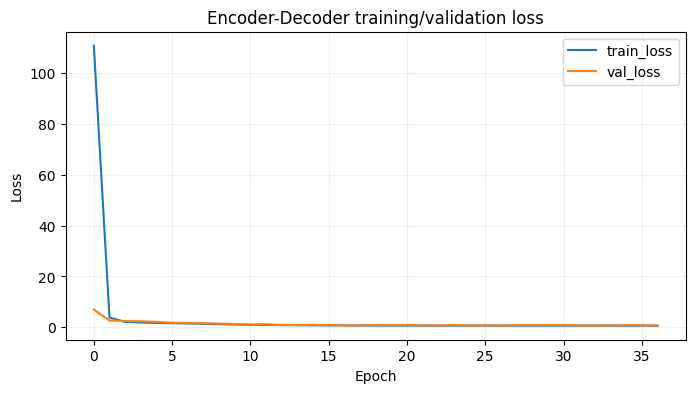

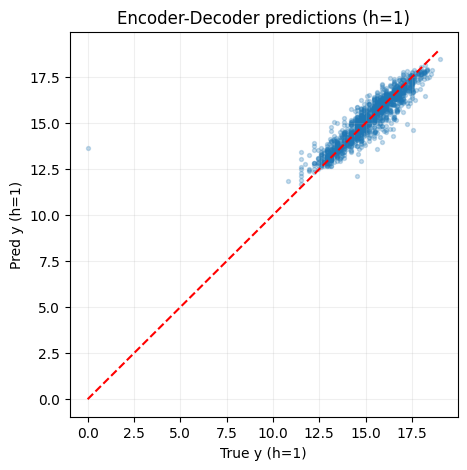

In [ ]:
# Cell H: Plots
# Loss curves
plt.figure(figsize=(8,4))
plt.plot(history_ed.history['loss'], label='train_loss')
plt.plot(history_ed.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Encoder-Decoder training/validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.2)
plt.savefig(OUT_BASE / "encoder_decoder_loss.png", dpi=150)
plt.show()

# Scatter for horizon 1 (next-season)
plt.figure(figsize=(5,5))
plt.scatter(Y_test[:,0], Y_pred[:,0], alpha=0.25, s=8)
plt.xlabel("True y (h=1)")
plt.ylabel("Pred y (h=1)")
plt.title("Encoder-Decoder predictions (h=1)")
plt.plot([Y_test[:,0].min(), Y_test[:,0].max()], [Y_test[:,0].min(), Y_test[:,0].max()], 'r--')
plt.grid(alpha=0.2)
plt.savefig(OUT_BASE / "encoder_decoder_scatter_h1.png", dpi=150)
plt.show()


# 📌 Milestone 4: LSTM Model Development – Summary

This notebook explored multiple LSTM architectures to predict player market values across seasons. Below are the models developed and their performance highlights:

---

##  1. Univariate LSTM
- **Target:** `target_log1p` only (no additional features).
- **Approach:** Sequence-to-one (predict next season’s value).
- **Result:**
  - RMSE: ~0.62
  - MAE: ~0.38
- **Takeaway:** The model successfully learned temporal patterns from historical market values alone.

---

##  2. Multivariate LSTM
- **Features used:** `target_log1p`, goals, assists, total_minutes, appearances_count, num_injuries, transfers_sum_fee, transfers_count, reddit_mean_compound, reddit_num_posts.
- **Approach:** Sequence-to-one with multiple predictors.
- **Result:**
  - RMSE: ~0.67
- **Takeaway:** Incorporating multiple features improves predictive accuracy over univariate.

---

##  3. Tuned Multivariate LSTM
- **Enhancements:**
  - Deeper stacked LSTM layers.
  - Lookback increased to 5 seasons.
  - Dropout regularization.
- **Result:**
  - RMSE: **0.52** (best single-step model so far).
- **Takeaway:** Tuning architecture significantly boosts accuracy for 1-step forecasts.

---

##  4. Encoder–Decoder LSTM (Multi-step Forecasting)
- **Goal:** Predict future player values over **3 seasons** (t+1, t+2, t+3).
- **Architecture:** Encoder LSTM → RepeatVector → Decoder LSTM → TimeDistributed(Dense).
- **Results (per horizon):**
  - Horizon 1 (next season): RMSE **0.66**
  - Horizon 2 (two seasons ahead): RMSE **0.74**
  - Horizon 3 (three seasons ahead): RMSE **0.88**
  - Overall Multi-step RMSE: **0.76**, MAE: **0.56**
- **Takeaway:** The model generalizes well for near-term forecasts (t+1), with expected degradation for longer horizons. Provides a strong foundation for multi-step forecasting.

---

##  Visual Diagnostics 📊
- **Training/Validation Loss Curves:** Both losses converged smoothly, showing no overfitting.
- **Prediction Scatter Plots (t+1):** Strong correlation between true and predicted values, with predictions clustering tightly around the ideal diagonal.

---

##  Milestone 4 Completed ✅
We have:
- Built univariate, multivariate, tuned, and encoder–decoder LSTM models.
- Achieved strong single-step and competitive multi-step performance.
- Saved all models, predictions, and metrics under:


#Folder Tree
```
player_value_prediction_project/  # Root: /content/drive/MyDrive/
│
└── data/
    └── processed/
        ├── .ipynb_checkpoints/
        │
        ├── archive/
        │   └── checkpoints_archive.zip
        │
        ├── checkpoints/
        │   ├── statsbomb_player_stats_batch_1.csv
        │   ├── statsbomb_player_stats_batch_2.csv
        │   ├── statsbomb_player_stats_batch_3.csv
        │   ├── statsbomb_player_stats_batch_4.csv
        │   ├── statsbomb_player_stats_batch_5.csv
        │   ├── statsbomb_player_stats_batch_6.csv
        │   ├── statsbomb_player_stats_batch_7.csv
        │   ├── statsbomb_player_stats_batch_8.csv
        │   └── statsbomb_player_stats_batch_9.csv
        │
        ├── features/
        │   ├── player_appearances_agg.csv
        │   ├── player_valuations_agg.csv
        │   ├── statsbomb_player_stats_all.csv
        │   ├── statsbomb_player_stats_derived.csv
        │   └── statsbomb_player_stats_pilot.csv
        │
        └── master/
            ├── backup_before_fe_20250906_154823.csv
            ├── final_training_master.csv
            ├── player_season_master.csv
            ├── player_season_master_with_injuries.csv
            ├── player_season_master_with_sentiment.csv
            ├── player_season_master_with_statsbomb.csv
            ├── player_season_master_with_statsbomb_shifted.csv
            ├── player_season_master_with_transfers.csv
            ├── players_processed.csv
            │
            └── sandbox/
                ├── final_training_master_fe.csv
                ├── final_training_master_fe_safe.csv
                ├── safe_features_list.csv
                ├── scaler_final_training_master_fe_20250906_154823.joblib
                │
                ├── diagnostics/
                │   ├── .ipynb_checkpoints/
                │   ├── corr_heatmap_top30.png
                │   ├── dist_age_at_season_start.png
                │   ├── dist_assists.png
                │   ├── dist_goals.png
                │   ├── dist_reddit_mean_compound.png
                │   ├── dist_total_minutes.png
                │   ├── dist_transfers_sum_fee.png
                │   ├── feature_target_correlations.csv
                │   ├── lgbm_top20_feature_importance.csv
                │   ├── lgbm_quick_feature_importance.csv
                │   ├── lgbm_safe_feature_importance.csv
                │   ├── missingness_percent.csv
                │   ├── sentiment_feature_importance_fixed.csv
                │   ├── sentiment_scatter_reddit_mean_compound.png
                │   ├── sentiment_scatter_reddit_neg_ratio.png
                │   ├── sentiment_scatter_reddit_num_posts.png
                │   ├── sentiment_scatter_reddit_pos_ratio.png
                │   ├── sentiment_scatter_reddit_subreddits_count.png
                │   ├── sentiment_target_correlations_fixed.csv
                │   ├── sentiment_target_correlations_pearson.csv
                │   ├── sentiment_target_correlations_spearman.csv
                │   └── target_and_lag_stats.csv
                │
                │
                └── models_lstm/                # Milestone 4 models
                    ├── univariate/
                    │   ├── lstm_univariate_best.h5
                    │   ├── lstm_univariate_predictions.csv
                    │   └── lstm_loss.png
                    │
                    ├── multivariate/
                    │   ├── lstm_multivariate_best.keras
                    │   ├── lstm_multivariate_predictions.csv
                    │
                    ├── multivariate_tuned/
                    │   ├── lstm_multivariate_tuned.keras
                    │   └── (optional predictions file)
                    │
                    └── encoder_decoder/         # Multi-step forecasts
                        ├── encoder_decoder_best.keras
                        ├── encoder_decoder_predictions.csv
                        └── encoder_decoder_metrics.csv

 ```                       